In [1]:
from src.makedata import *
from src.makemodel import *
from src.time import *

In [2]:
# return dataloader for training/testing datasets, containing a dict of ["img"],["msk"],["name"] for each data point
batch = 8 # batch size in dataloader
dataname="nonsclerotic" 
phases=["train","val"]  # dataset hdfs5 name format: dataname_phase
shuffle = True 
dataLoader = {} # load data
for phase in phases:
    dataLoader[phase] = Data_Loader(dataname,phase,batch,shuffle) 
    dataset_size = len(dataLoader[phase])
    print('%s images = %d' % (phase, dataset_size))

train images = 193
val images = 193


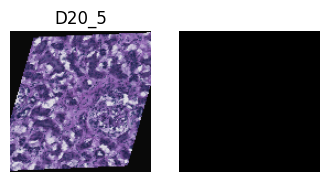

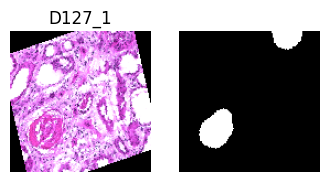

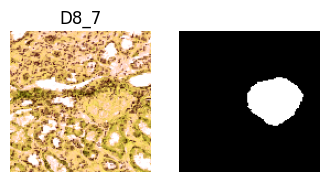

In [3]:
dataLoader["train"].vis_data() # visualize training patch with nonsclerotic glomeruli groundtruth mask   

In [4]:
isTrain = True  # set to False when using model in testing process
isContinue = False  # train from former saved model weights
savedir = "./log/"  # save path for model weights we want to save
loadpath = ""  # loadpath for saved models for continue training or testing  
num_epochs = 1000 # training epoches

In [5]:
# create/load model
model = GlomNet(isTrain, isContinue, savedir, loadpath, "UNet")

[CREATE] MODEL
UNet
UNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (

In [7]:
phases = ["train","val"]
start_time = time.time()
best_loss_on_test = np.Infinity
device = model.get_device()
#model.set_lr(0.0001) # default lr is 0.001, which can adjusted if want 
print(f"Device is {device}")
# start training 
for epoch in range(num_epochs):
    # accumulate loss for batches
    print(f"epoch {epoch}")
    all_loss = {key: torch.zeros(0).to(device) for key in phases}
    
    for phase in phases:
        if phase == "train":
            model.set_train()  # set model to training mode
        else: 
            model.set_eval()  # set model to testing mode
        print(f"phase is {phase}")
        # for each of the batches
        for ii , data in enumerate(dataLoader[phase]): 
            # input batch image NXCXHXW and mask NxHXW
            model.set_input(data["img"],data["msk"])
            if phase == "train":
                model.forward()
                model.backward()
            else:
                model.validate() # enable no_grad, speed up
            all_loss[phase]=torch.cat((all_loss[phase],model.get_loss().detach().view(1,-1)))
        print(f"all_loss = {all_loss[phase]}\t\t len {len(all_loss[phase])}")
        all_loss[phase] = all_loss[phase].cpu().numpy().mean()
        print(f"Mean Loss {all_loss[phase]}")
        
            
    print('%s ([%d/%d] %d%%), train loss: %.4f test loss: %.4f' % (timeSince(start_time, (epoch+1) / num_epochs), 
            epoch+1, num_epochs ,(epoch+1) / num_epochs * 100, all_loss["train"], all_loss["val"]),end="")
    
    # save model weights with lowest validation loss
    if all_loss["val"] < best_loss_on_test:
        best_loss_on_test = all_loss["val"]
        print("  **")
        model.save_networks("UNet_nonscl_pre{}*.pth".format(epoch),epoch)
    else:
        print(" ")
    # simple learning rate linear decrease every 40 epoches, which can also be adjusted 
    if ((epoch+1)%40==0):
        model.update_lr()

Device is cpu
epoch 0
phase is train
curr_time = 0
curr_time = 1
curr_time = 2
curr_time = 3
curr_time = 4
curr_time = 5
curr_time = 6
curr_time = 7
curr_time = 8
curr_time = 9
curr_time = 10
curr_time = 11
curr_time = 12
curr_time = 13
curr_time = 14
curr_time = 15
curr_time = 16
curr_time = 17
curr_time = 18
curr_time = 19
curr_time = 20
curr_time = 21
curr_time = 22
curr_time = 23
curr_time = 24
all_loss = tensor([[0.5725],
        [0.5851],
        [0.4920],
        [0.4507],
        [0.3942],
        [0.3511],
        [0.3246],
        [0.3012],
        [0.3077],
        [0.2552],
        [0.2621],
        [0.2286],
        [0.2507],
        [0.2175],
        [0.1998],
        [0.2071],
        [0.1758],
        [0.1811],
        [0.1764],
        [0.1722],
        [0.1744],
        [0.1642],
        [0.1682],
        [0.1444],
        [0.3071]])		 len 2
phase is val
curr_time = 0
curr_time = 1
curr_time = 2
curr_time = 3
curr_time = 4
curr_time = 5
curr_time = 6
curr_time = 7
cur

In [14]:
print(all_loss[phase].mean())
print(phase)

0.15100712
val
